In [1]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from wordcloud import WordCloud, STOPWORDS
from matplotlib import rcParams
import operator

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Introduction

We wanted to conduct sentiment analysis in order to examine the emotions within text. This is growing more important in society today because businesses want to be able to analyze user sentiment to get a read on their customers. To analyze this, we looked at Yelp reviewers, particularly through both the ratings and the reviews they provide, with this question in mind: 
* How well does sentiment analysis work on Yelp reviews?

# Reading in Data

## CSV file from 'business.json'

In [4]:
# Reading in 'extacted_restaurants_from_business.csv'
rest_biz_csvTOpd = pd.read_csv('extracted_restaurants_from_business.csv')

In [5]:
# Business IDs for the restaurants
restaurant_id_list = rest_biz_csvTOpd.business_id.tolist()
restaurant_id_list[:5]

['QXAEGFB4oINsVuTFxEYKFQ',
 'gnKjwL_1w79qoiV3IC_xQQ',
 '1Dfx3zM-rW4n-31KeC8sJg',
 'fweCYi8FmbJXHCqLnwuk8w',
 'PZ-LZzSlhSe9utkQYU8pFg']

In [6]:
print('Number of restaurants in the original dataset:',len(restaurant_id_list))

Number of restaurants in the original dataset: 59371


## CSV file from 'review.json'

In [7]:
# Reading in 'extracted_restaurants_from_review.csv'
rest_review_csvTOpd = pd.read_csv('extracted_restaurants_from_review.csv')

In [8]:
# Rename column containing the old indices
rest_review_csvTOpd.rename(columns={"Unnamed: 0": "Index_From_review.JSON"}).head()

Index_From_review.JSON               review_id             business_id  \
0                      3  yi0R0Ugj_xUx_Nek0-_Qig  ikCg8xy5JIg_NGPx-MSIDA   
1                      5  fdiNeiN_hoCxCMy2wTRW9g  eU_713ec6fTGNO4BegRaww   
2                      6  G7XHMxG0bx9oBJNECG4IFg  3fw2X5bZYeW9xCz_zGhOHg   
3                      7  8e9HxxLjjqc9ez5ezzN7iQ  zvO-PJCpNk4fgAVUnExYAA   
4                     10  kbtscdyz6lvrtGjD1quQTg  8mIrX_LrOnAqWsB5JrOojQ   

   stars                                               text  
0    5.0  Went in for a lunch. Steak sandwich was delici...  
1    4.0  I'll be the first to admit that I was not exci...  
2    3.0  Tracy dessert had a big name in Hong Kong and ...  
3    1.0  This place has gone down hill.  Clearly they h...  
4    4.0  Like walking back in time, every Saturday morn...

# Exploratory Data Analysis of reviews.json

## Metrics

In [9]:
def all_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
    print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'), 4))
    print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
    print('F1-Score:', np.round(metrics.f1_score(true_labels, predicted_labels,average='weighted'), 4))

## Number of Reviews

In [10]:
rest_review_length = len(rest_review_csvTOpd)
print("There are {} restaurant reviews.".format(rest_review_length))

There are 4201685 restaurant reviews.


In [11]:
one_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 1.0]
two_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 2.0]
three_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 3.0]
four_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 4.0]
five_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 5.0]

In [12]:
# Figuring out what percentage of the "rest_review_csvTOpd" should be training data, and what percentage should be test data.
num_train_data = int(rest_review_length * 0.8)
print("For 80% of the data, there should be {} reviews.".format(num_train_data))

For 80% of the data, there should be 3361348 reviews.


# Modeling

## Modeling with 5 Labels

### Histogram of All Reviews in review.json

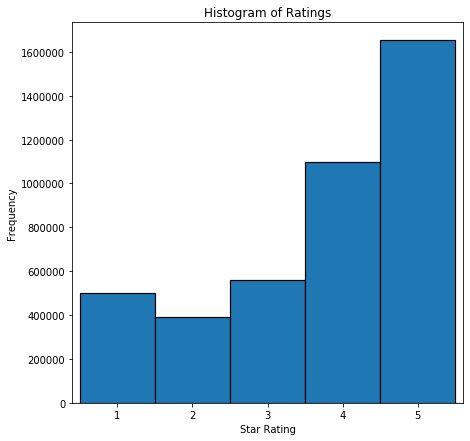

In [13]:
plt.figure(figsize=(7,7))
plt.hist(rest_review_csvTOpd.stars, bins=np.arange(10)-0.5, edgecolor='black', linewidth=1.2)
plt.xlim(0.4, 5.6)
plt.title("Histogram of Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Frequency")
plt.show()

### Data

* We subset the data in order to make the analysis run much faster.

In [14]:
# Train data for FIVE labels with equal amounts of each rating.
train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], three_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
train_labels = pd.concat([one_star.stars[:1600], two_star.stars[:1600], three_star.stars[:1600], four_star.stars[:1600], five_star.stars[:1600]])

# Test data for FIVE labels with equal amounts of each rating.
test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], three_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
test_labels = pd.concat([one_star.stars[1600:1700], two_star.stars[1600:1700], three_star.stars[1600:1700], four_star.stars[1600:1700], five_star.stars[1600:1700]])

### Histogram of Train Data

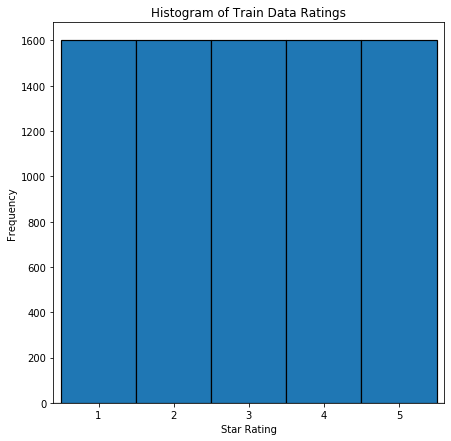

In [15]:
plt.figure(figsize=(7,7))
plt.hist(train_labels, bins=np.arange(10)-0.5, edgecolor='black', linewidth=1.2)
plt.xlim(0.4, 5.6)
plt.title("Histogram of Train Data Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Frequency")
plt.show()

### CountVectorizer

In [16]:
# Fit CountVectorizer with your text data
cvector = CountVectorizer()
# train_data = testset.text.tolist()
vtrain = cvector.fit_transform(train_data)
vtest = cvector.transform(test_data)

In [17]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.09)
lr_classifier.fit(vtrain, train_labels)
train_predicted_labels = lr_classifier.predict(vtest)
all_metrics(test_labels, train_predicted_labels)

Accuracy: 0.51
Precision: 0.5038
Recall: 0.51
F1-Score: 0.5059


#### Confusion Matrix for CountVectorizer

In [18]:
print(confusion_matrix(test_labels, train_predicted_labels))

[[69 23  5  3  0]
 [27 38 27  5  3]
 [ 6 21 42 25  6]
 [ 4  8 11 40 37]
 [ 1  2  4 27 66]]


* Note: Rows reflect the actual values. Columns reflect the predicted values.
* Fairly standard confusion matrix with the majority of test_labels and predicted_labels predicted correctly.

### TfidfVctorizer

In [19]:
# Fit TfidfVectorizer with your text data
tvector = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2))
vtrain = tvector.fit_transform(train_data)
vtest = tvector.transform(test_data)
tvector.fit(test_data)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [20]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.09)
lr_classifier.fit(vtrain, train_labels)
train_predicted_labels = lr_classifier.predict(vtest)
all_metrics(test_labels, train_predicted_labels)

Accuracy: 0.494
Precision: 0.4819
Recall: 0.494
F1-Score: 0.4808


#### Confusion Matrix for TfidfVectorizer

In [21]:
print(confusion_matrix(test_labels, train_predicted_labels))

[[70 22  5  0  3]
 [27 29 31  5  8]
 [ 5 17 53 13 12]
 [ 4  8 23 27 38]
 [ 1  5  8 18 68]]


* What's interesting about this particular matrix is the 4th row. About 38 reviews are predicted to be 5-star reviews, but in actuality they are 4-star reviews of the restaurant. The number of predicted 5-star reviews for ones that are actually 4-star reviews shows that it is difficult to distinguish a 4-star review from a five star one. One possible reason for this is because people often reserve a 5-star style meal for truly exceptional meals. Thus even though they talk about positive aspects of the meal in their 4-star rating, they could be giving the review 4-stars just because it wasn't the "best". 

* This result prompted us to think about working with less labels rather than the current schema of 5 labels, one for each star rating. Perhaps with less labels, it will be much clearer to distinguish clearer difference between labels.

## Modeling with Simplified Labels

### Data

In [22]:
# Train data for 3 labels with equal amounts of each rating.
train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], three_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], three_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], three_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], three_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

* The simplified data essentially simplified the 5-star rating system into three bins: bad reviews, neutral reviews, and good reviews.

### Histogram of Simplified Train Data

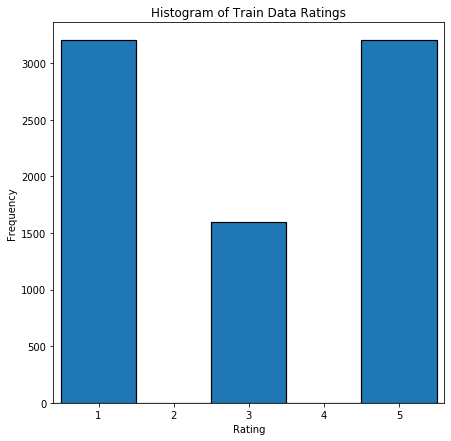

In [23]:
plt.figure(figsize=(7,7))
plt.hist(train_labels, bins=np.arange(10)-0.5, edgecolor='black', linewidth=1.2)
plt.xlim(0.4, 5.6)
plt.title("Histogram of Train Data Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

* Here, the 1-star and 2-star ratings were the bad reviews, the 3-star rating consisted of the neutral reviews, and the 4-star and the 5-star ratings were the good reviews.

### CountVectorizer

In [24]:
# Fit CountVectorizer with your text data
cvector = CountVectorizer()
vtrain = cvector.fit_transform(train_data)
vtest = cvector.transform(test_data)

In [25]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.09)
lr_classifier.fit(vtrain, train_labels)
train_predicted_labels = lr_classifier.predict(vtest)
all_metrics(test_labels, train_predicted_labels)

Accuracy: 0.778
Precision: 0.7645
Recall: 0.778
F1-Score: 0.7646


#### Confusion Matrix for CountVectorizer

In [26]:
print(confusion_matrix(test_labels, train_predicted_labels))

[[169  15  16]
 [ 33  39  28]
 [ 10   9 181]]


## Sample Predictions

In [27]:
# Fit CountVectorizer with your text data
cvector = CountVectorizer()
vtrain = cvector.fit_transform(train_data)
vtest = cvector.transform(test_data)

In [28]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.09)
lr_classifier.fit(vtrain, train_labels)
train_predicted_labels = lr_classifier.predict(vtest)
all_metrics(test_labels, train_predicted_labels)

Accuracy: 0.778
Precision: 0.7645
Recall: 0.778
F1-Score: 0.7646


In [29]:
# Predict new sentence #1.
test_sentence = ["I hate this place"]
new_test = cvector.transform(test_sentence)
lr_classifier.predict(new_test)
lr_classifier.predict_proba(new_test)

array([[0.47168233, 0.172166  , 0.35615168]])

In [30]:
# Predict new sentence #2.
test_sentence = ["Great place"]
new_test = cvector.transform(test_sentence)
lr_classifier.predict(new_test)
lr_classifier.predict_proba(new_test)

array([[0.25371724, 0.15154494, 0.59473782]])

For sentence #1, the model predicts the review to be a negative review, whereas the model predicts that sentence #2 is most likely a positive review.

# Predictions Without Neutral Reviews

In [31]:
# Redoing Analysis with Neutral Reviews
NO3_train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
NO3_train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

NO3_test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
NO3_test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

### CountVectorizer

In [32]:
# Fit CountVectorizer with your text data
cvector = CountVectorizer()
v_NO3_train = cvector.fit_transform(NO3_train_data)
v_NO3_test = cvector.transform(NO3_test_data)

In [33]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.08)
lr_classifier.fit(v_NO3_train, NO3_train_labels)
train_predicted_labels = lr_classifier.predict(v_NO3_test)
all_metrics(NO3_test_labels, train_predicted_labels)

Accuracy: 0.9175
Precision: 0.918
Recall: 0.9175
F1-Score: 0.9175


#### Confusion Matrix for CountVectorizer

In [34]:
print(confusion_matrix(NO3_test_labels, train_predicted_labels))

[[180  20]
 [ 13 187]]


### TfidfVctorizer

In [35]:
# Fit TfidfVectorizer with your text data
tvector = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2))
v_NO3_train = tvector.fit_transform(NO3_train_data)
v_NO3_test = tvector.transform(NO3_test_data)

In [36]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.09)
lr_classifier.fit(v_NO3_train, NO3_train_labels)
train_predicted_labels = lr_classifier.predict(v_NO3_test)
all_metrics(NO3_test_labels, train_predicted_labels)

Accuracy: 0.8675
Precision: 0.8682
Recall: 0.8675
F1-Score: 0.8674


#### Confusion Matrix for TfidfVectorizer

In [37]:
print(confusion_matrix(NO3_test_labels, train_predicted_labels))

[[178  22]
 [ 31 169]]


* So if we throw out the moderate data (the 3-star reviews), it is clear that there is a difference between positive and negative reviews. What are some of those differences in vocabulary though?

# Word Cloud

* Since we're looking to compare reviews written from either end of the spectrum of restraunt ratings, the data that we're looking to train will only consist of the extremes. 

In [38]:
cloud_train_data = pd.concat([one_star.text[:1600], five_star.text[:1600]]).tolist()
cloud_train_labels = pd.concat([one_star.stars[:1600], five_star.stars[:1600]])

## General Word Cloud

In [67]:
# Stopwords are words that are commonly used that have been purposefully programmed to be ignored.
stopwords = STOPWORDS
stopwords.add('food')
stopwords.add('place')
stopwords.add('ve')
stopwords.add('don')

In [68]:
# Here we're looking to 
general = " ".join(cloud_train_data)
wordcloud = WordCloud(stopwords = stopwords, width=1600, height=800, max_font_size=200).generate(general)

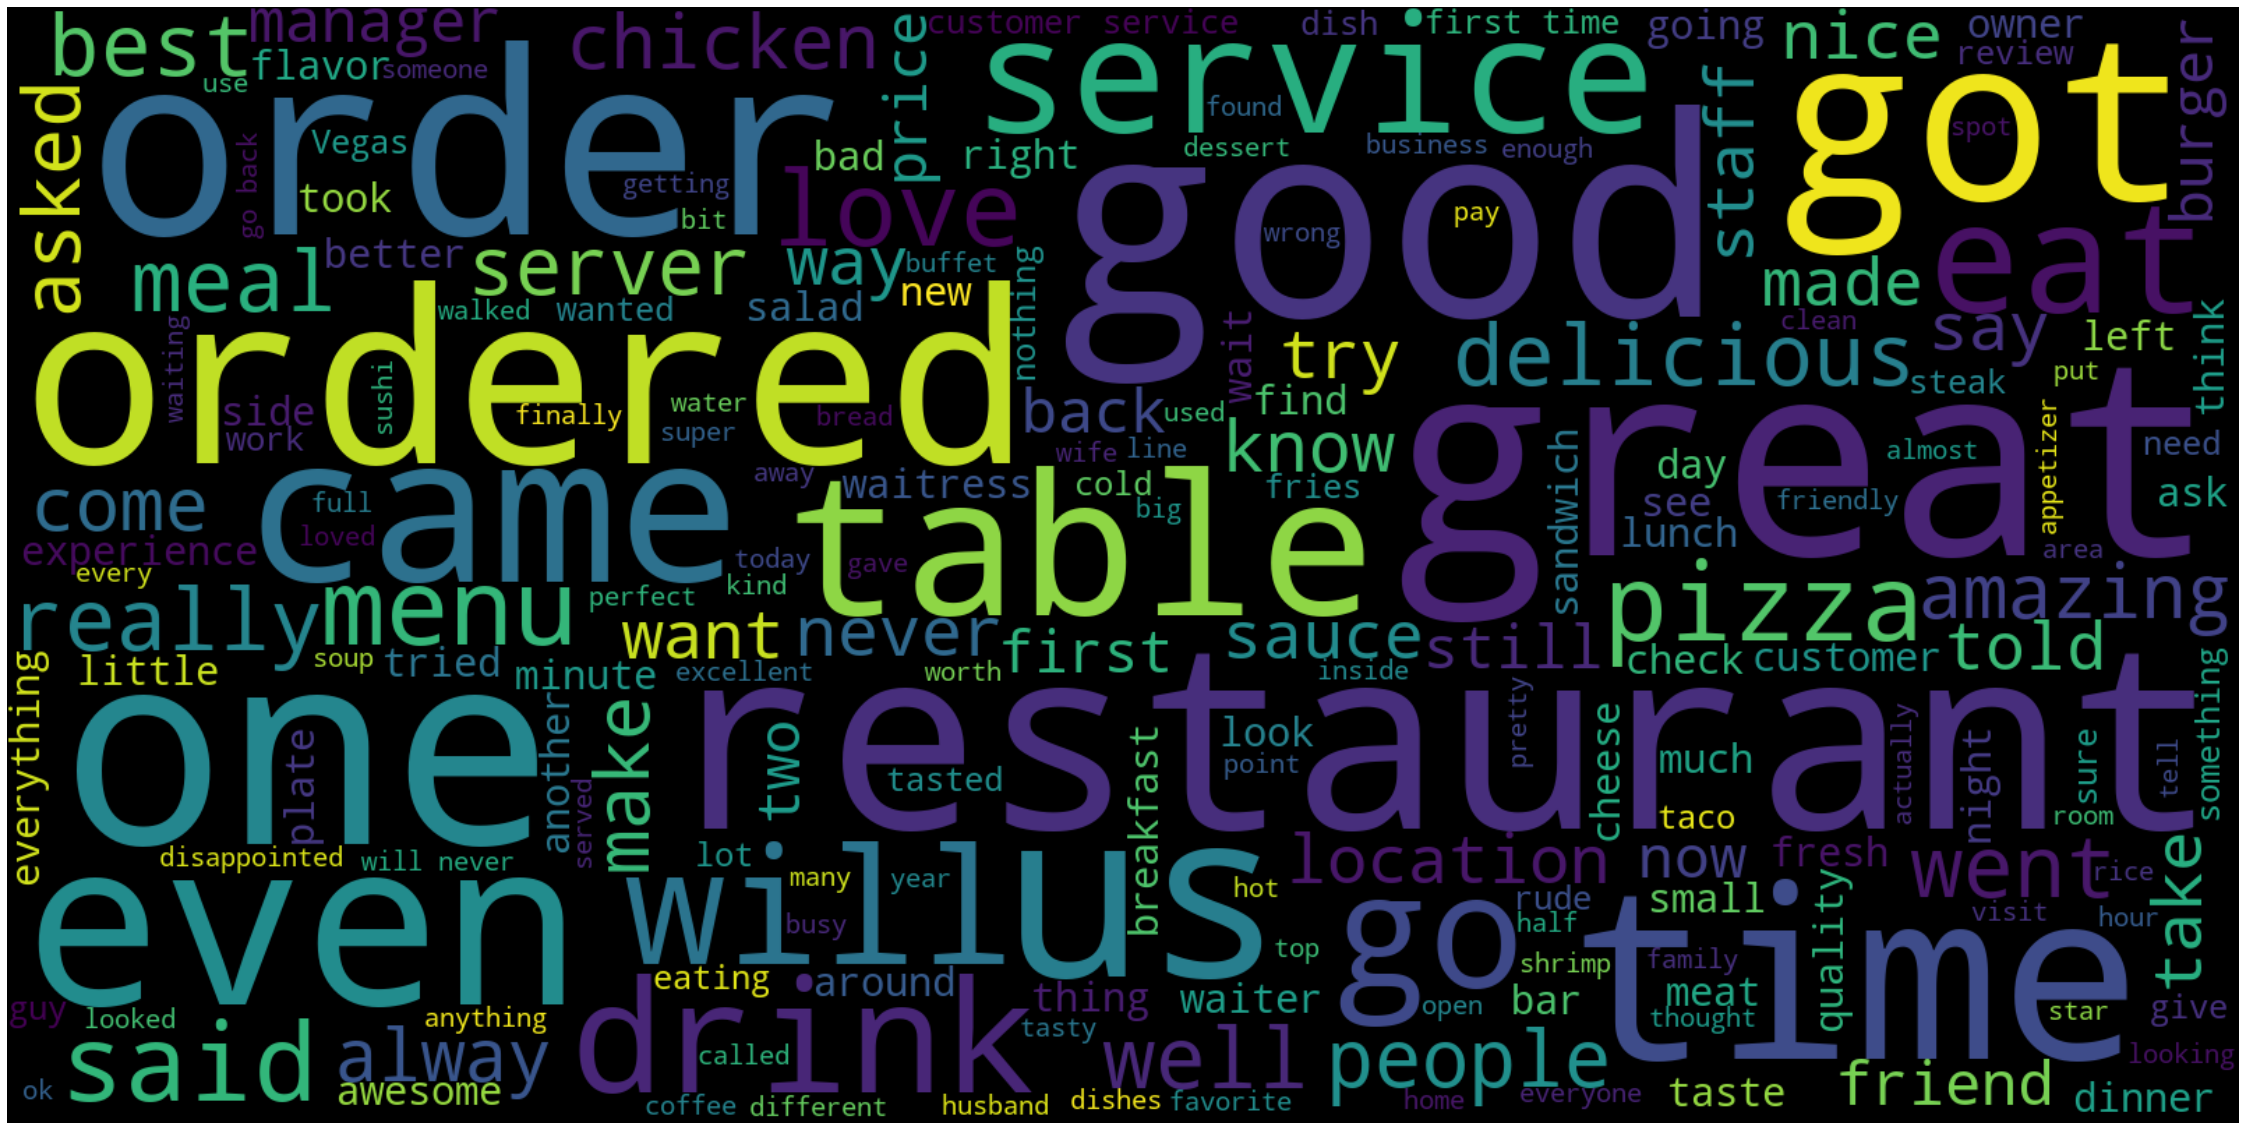

In [69]:
rcParams['figure.figsize'] = 40, 40
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()

## General Word Cloud with Positive Reviews

In [70]:
# Positive Reviews Dataset
positive_reviews = five_star.text[1600:2000].tolist()
positive = " ".join(positive_reviews)

In [71]:
wordcloud = WordCloud(stopwords = stopwords, width=1600, height=800, max_font_size=200).generate(positive)

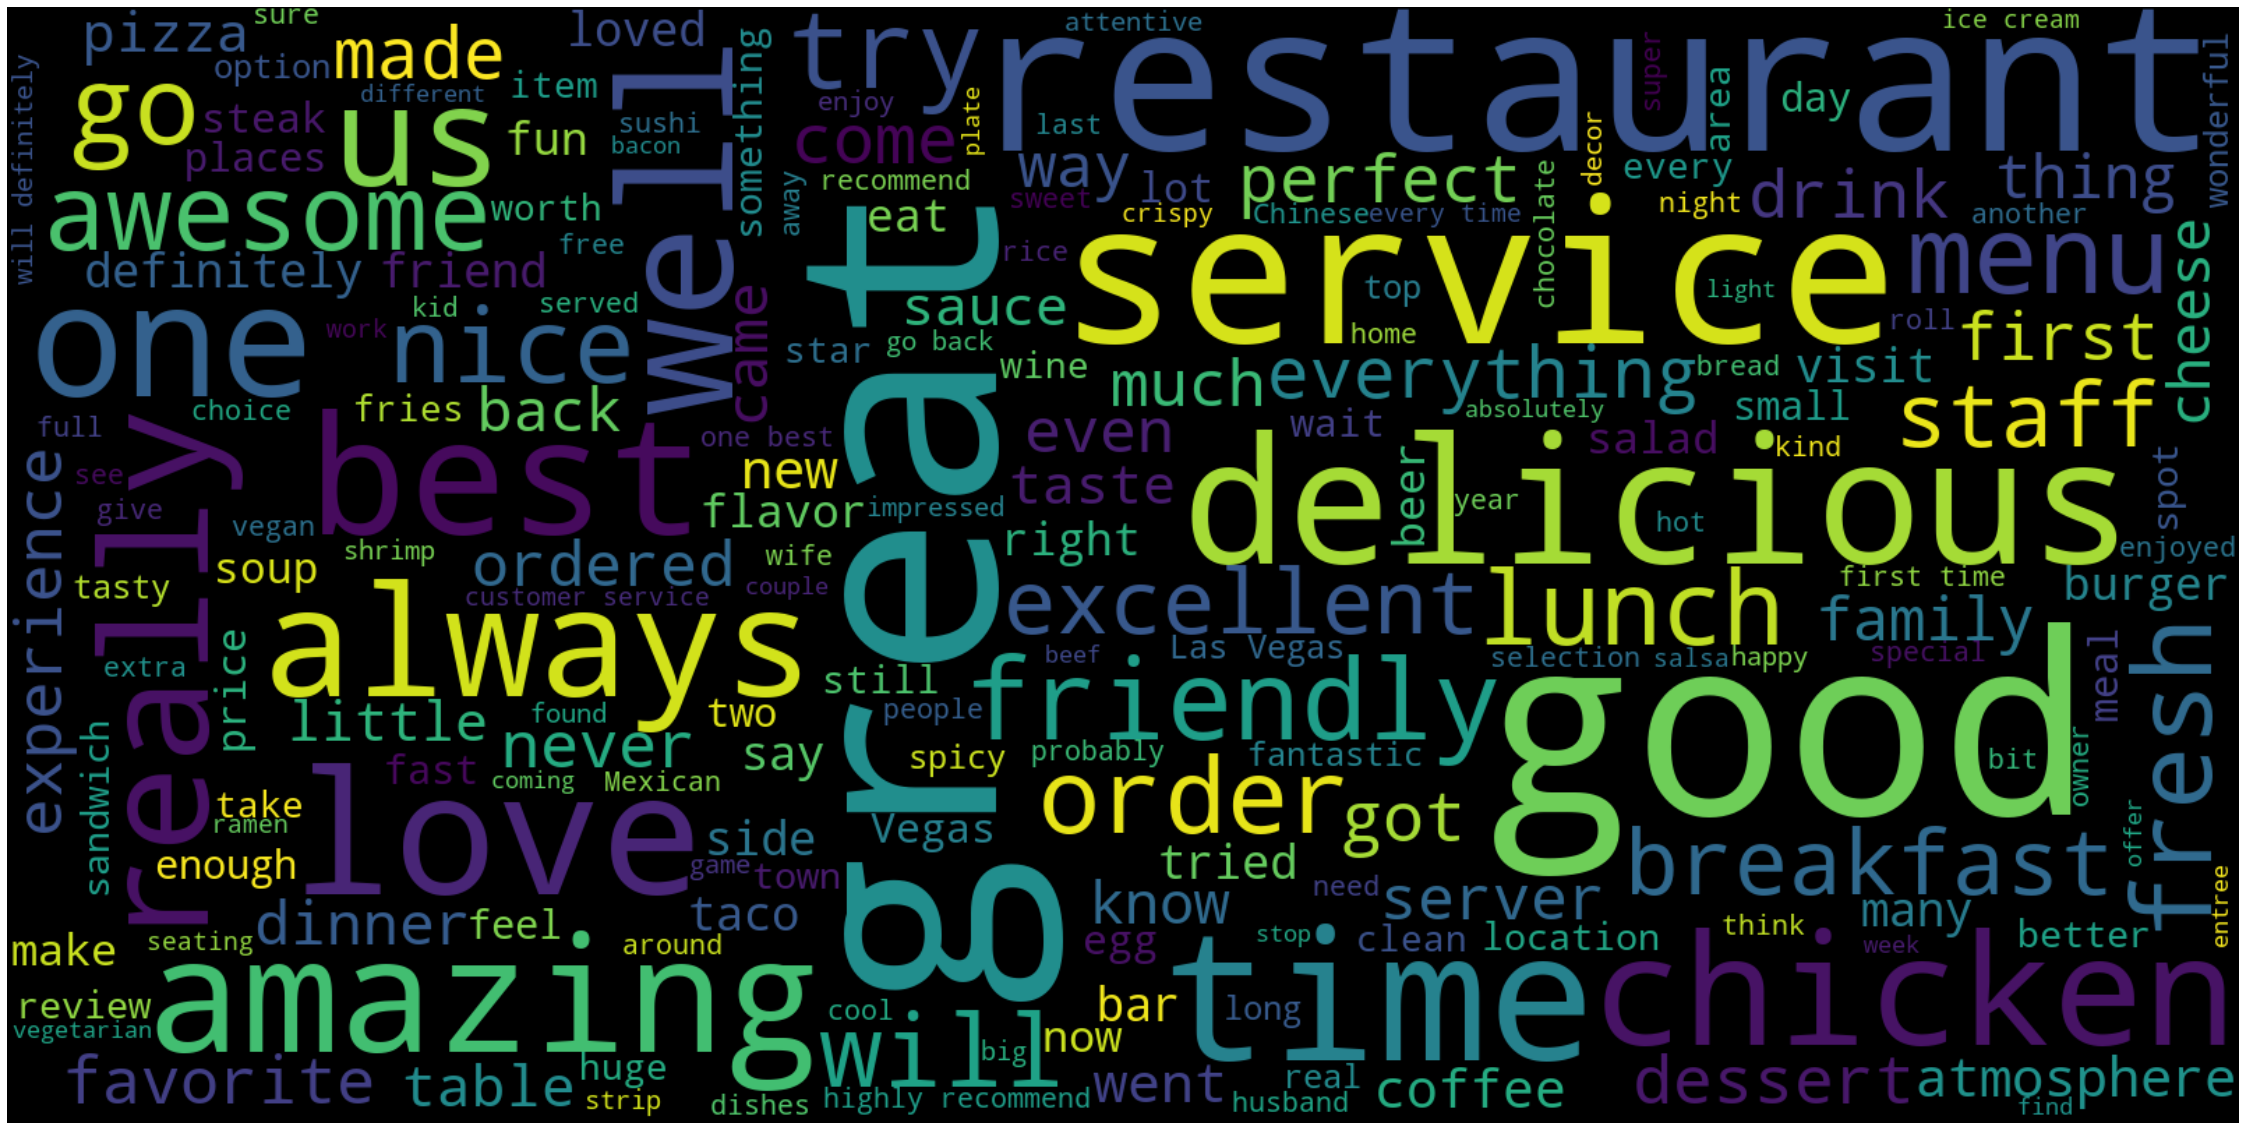

In [72]:
rcParams['figure.figsize'] = 40, 40
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()

## General Word Cloud with Negative Reviews

In [73]:
# Negative Reviews Dataset
negative_reviews = one_star.text[1600:2000].tolist()
negative = " ".join(negative_reviews)

In [74]:
wordcloud = WordCloud(stopwords = stopwords,width=1600, height=800, max_font_size=200).generate(negative)

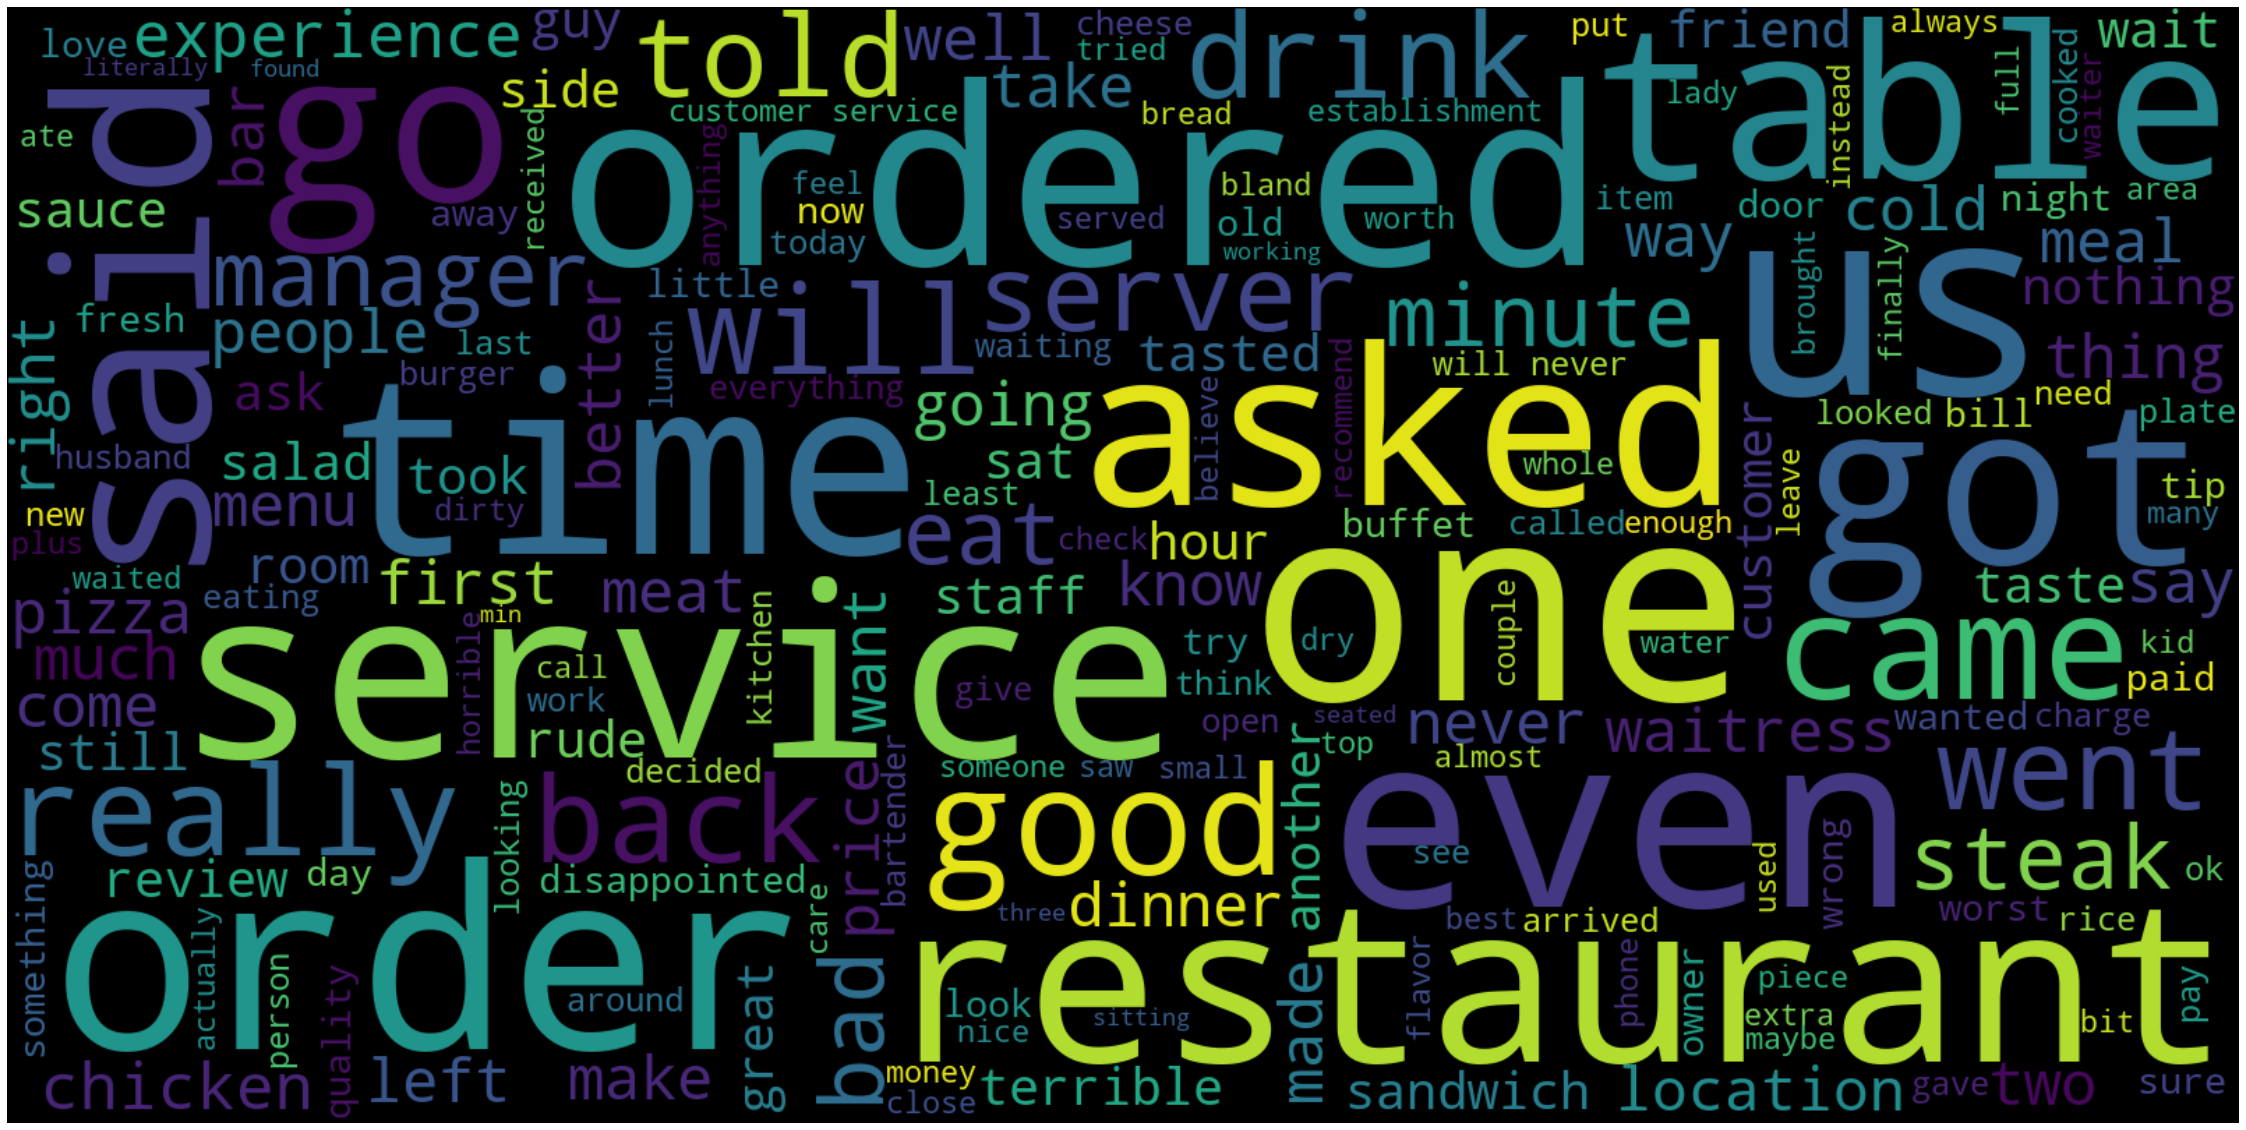

In [75]:
rcParams['figure.figsize'] = 40, 40
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()

# Count Vectorizer

In [76]:
cvector = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2))
cvector.fit(cloud_train_data)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [77]:
len(cvector.get_feature_names())

134907

## Positive Reviews

In [78]:
pos_matrix = cvector.transform(positive_reviews)
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
pos_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])

In [79]:
positive_unique_terms = pos_tf[~pd.DataFrame(pos_tf.Terms.tolist()).isin(stopwords).any(1)]
positive_unique_terms[:20]

Terms  positive
22       great       223
26        good       187
29     and the       155
30     service       152
35      of the       139
37        time       119
39  this place       117
40        best       117
41  restaurant       116
43    the food       113
44         one       113
45   delicious       110
50      it was       104
51        back       103
56          go        94
57        love        94
59    the best        92
61        well        87
63     amazing        86
64        will        85

## Negative Reviews

In [80]:
neg_matrix = cvector.transform(negative_reviews)
neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])

In [81]:
negative_unique_terms = neg_tf[~pd.DataFrame(neg_tf.Terms.tolist()).isin(stopwords).any(1)]
negative_unique_terms[:20]

Terms  negative
36      it was       177
38         one       173
40        back       170
41     service       170
43          us       164
48        time       147
49        even       144
52       order       134
53     ordered       134
55      of the       131
56        will       131
57  this place       130
58          go       130
60       never       128
61        came       126
66      in the       121
67         got       121
68        didn       117
72        good       112
73       asked       112

# Tfidf Vectorizer

In [82]:
tvector = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2))
tvector.fit(cloud_train_data)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

### Positive Reviews

In [83]:
pos_matrix = tvector.transform(positive_reviews)
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in tvector.vocabulary_.items()]
pos_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])

In [84]:
positive_unique_terms = pos_tf[~pd.DataFrame(pos_tf.Terms.tolist()).isin(stopwords).any(1)]
positive_unique_terms[:20]

Terms   positive
8        great  10.074095
19        good   7.060764
24     and the   6.232548
25     service   6.200161
26   delicious   6.015553
28     amazing   5.808566
30        best   5.678902
31        love   5.558969
34    friendly   5.515190
38  this place   5.075886
39    the food   5.041607
40    the best   5.030140
41  restaurant   4.587936
42      always   4.556567
45        time   4.414253
48      of the   4.113231
50    favorite   4.064171
51     chicken   3.982573
53         one   3.809039
56      it was   3.764781

* TF-IDF analysis reveals a more words that are unique to the particular subset of positive reviews. Some words like "great", "good", and "delicious" are easy to understand, but then there are certain features of restaurants that get mentioned a lot too in these positive reviews, like the "service", "place", and the "time", presumably talking about the positive aspects of the particular restaurant.

## Negative Reviews

In [85]:
neg_matrix = tvector.transform(negative_reviews)
neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in tvector.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])

In [86]:
negative_unique_terms = neg_tf[~pd.DataFrame(neg_tf.Terms.tolist()).isin(stopwords).any(1)]
negative_unique_terms[:20]

Terms  negative
31     service  5.229075
33        even  5.096261
39       never  4.862974
41        back  4.776545
43      it was  4.724989
44          us  4.691151
45       order  4.687237
46         one  4.586205
52        time  4.286683
53         got  4.284274
54     minutes  4.271214
55        will  4.253893
56         bad  4.199710
58     ordered  4.120821
59  this place  4.108731
63        came  3.905639
64       asked  3.883210
66          go  3.834852
67    the food  3.816982
70        didn  3.784557

* On the other hand, the negative reviews focus on aspects of the restaurant like the "service", the "order", the "time", "the food", and the "place", as well as words that describe those aspects, like "bad".

# Limitations

* The Training was conducted using peoples' reviews. Thus, it is limited in that it is using people's subjective ratings of the meal, particularly in the number of stars that they rate a particular restaurant. Perhaps someday, sentiment analysis will be robust enough to only utlize reviews to gauge the quality of a restaurant.
* Another limitation is that the reviews obtained are of a holistic evaluation of the restaurant. There is nothing to distinguish between the food and the decor for instance, so it is limited in that sense.

# Looking Forward

* We could look to run the ML techniques to on the entirety of the set with more computing power to get a more complete picture of the data.